In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import random

from tensorflow.keras import models, layers, Input, optimizers, initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.feature_extraction.text import CountVectorizer

from Code.utils.dataset import Dataset


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrjoa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
value_seed=42
np.random.seed(value_seed)
tf.random.set_seed(value_seed)
random.seed(value_seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
embeddings_initializer=initializers.GlorotUniform(seed=42)

def build_model(hp):
    min_hidden = 4
    max_hidden = 32

    model = models.Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    hp1_units = hp.Int('hidden1_units', min_value=min_hidden, max_value=max_hidden, step=4)
    model.add(SimpleRNN(hp1_units, activation='sigmoid'))

    model.add(Dense(1, activation='sigmoid'))

    #compilar modelo
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.2, 0.001])
    hp_momentum = hp.Choice('momentum', values=[0.2, 0.3, 0.5])
    #hp_beta_1 = hp.Choice('beta_1', values=[0.9, 0.99])
    #hp_beta_2 = hp.Choice('beta_2', values=[0.9, 0.999])
    hp_batch = hp.Choice('batch_size', values=[4, 8, 16])


    optimizer = SGD(learning_rate=hp_learning_rate,
                    momentum=hp_momentum)

    #optimizer = Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    return model

In [3]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/dataset1_inputs.csv',
                  '../../Dataset/dataset1_outputs.csv')

# Remover pontuação deu pior resultado
X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_dataset_embedding('Text', 'Label', sep='\t', rem_punctuation=False)

In [4]:
epochs_train = 10
# Start tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_acc',
    max_epochs=epochs_train,
    factor=3,
    directory='./KerasTuner',  # Directory to store results
    project_name='RNN_Tuning_1_Layers'
)

early_stopping = EarlyStopping(monitor='val_acc', patience=3, min_delta=0.001, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=epochs_train, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

Trial 30 Complete [00h 00m 10s]
val_acc: 0.6729999780654907

Best val_acc So Far: 0.9620000123977661
Total elapsed time: 00h 02m 16s


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.6035 - loss: 0.6515 - val_acc: 0.7900 - val_loss: 0.4674
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8025 - loss: 0.4532 - val_acc: 0.6480 - val_loss: 0.9554
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8009 - loss: 0.4486 - val_acc: 0.8380 - val_loss: 0.3741
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.7403 - loss: 0.5160 - val_acc: 0.6260 - val_loss: 0.6791
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.5816 - loss: 0.6789 - val_acc: 0.6810 - val_loss: 0.6025
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.6707 - loss: 0.6204 - val_acc: 0.7280 - val_loss: 0.5695


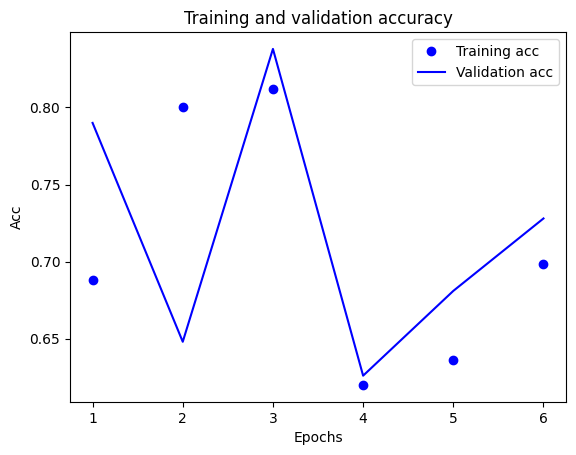

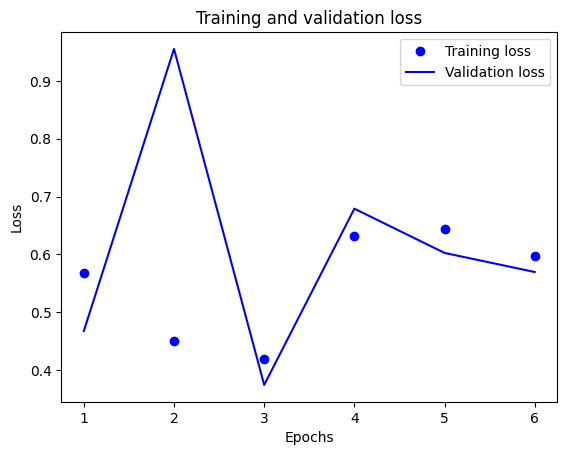

Hidden Layer 1 has 24 units
Optimizer learning rate = 0.2
Optimizer batch size = 16
Optimizer momentum = 0.5


[0.7335819005966187, 0.6000000238418579]

In [5]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

n_features = X_train.shape[1]

hidden1_units = best_hps['hidden1_units']
learning_rate = best_hps['learning_rate']
momentum = best_hps['momentum']
#beta_1 = best_hps['beta_1']
#beta_2 = best_hps['beta_2']
batch_size = best_hps['batch_size']


model = models.Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(hidden1_units, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))

#compilar modelo
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

#optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=epochs_train, batch_size=batch_size, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# Plot accuracy curves
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


print(f"Hidden Layer 1 has {hidden1_units} units")
print(f"Optimizer learning rate = {learning_rate}")
#print(f"Optimizer beta_1 = {beta_1}")
#print(f"Optimizer beta_2 = {beta_2}")
print(f"Optimizer batch size = {batch_size}")
print(f"Optimizer momentum = {momentum}")

# Evaluate Model
results = model.evaluate(X_test, y_test, verbose = 0)
results

In [6]:
# Predict test dataset

out = model.predict(X_test)

if y_test is not None:
    print(model.evaluate(X_test, y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.6125 - loss: 0.7367
[0.7335819005966187, 0.6000000238418579]


In [7]:
# Store results

results_filepath = './Results/rnn_tuner_1_layers_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, out)
results.to_csv(results_filepath, sep='\t', index=False)

In [8]:
dataset.set_dataset_test('../../Dataset/dataset1_inputs.csv', '../../Dataset/dataset1_outputs.csv')

X_test, y_test, ids = dataset.get_test_dataset_embedding('Text', 'Label', sep='\t', rem_punctuation=False)